In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Set2", 10))

### 2.1 Testing the testbed

*Which method will perform best in the long run in terms of cumulative reward and cumulative probability of selecting the best action? How much better will it be? Express your answer quantitatively.*

As we can see from the plots below, ε-greedy strategy with tuned ε can be ~30% better in terms of cumulative reward than just greedy strategy. Though, if we choose some crazy ε, it may be much worse than a greedy algorithm.

In [58]:
N_EPOCHS = 1000
EPS = [0,0.01,0.1, 0.2, 0.3, 0.5]
N_BANDITS = 10
N_EXPERIMENTS = 2000


def run_bandit_experiment(n_bandits=10, n_epochs=1000, n_exp=2000, eps=[0,0.01,0.1]):
    rewards = np.zeros((len(eps), n_epochs, n_exp))
    best_actions = np.zeros((len(eps), n_epochs, n_exp))
    for exp in range(n_exp):
        #generate a problem
        q = np.random.normal(size=N_BANDITS)
        
        best_bandit = np.argmax(q)
        for e in range(len(eps)):
            Q = np.zeros(n_bandits)
            N = np.zeros(n_bandits)
            for i in range(n_epochs):
                #noisy_reward = np.array([np.random.normal(loc=Q[i]) for i in range(N_BANDITS)])
                REWS = [np.random.normal(loc=q[i]) for i in range(N_BANDITS)]
                if np.random.random() < eps[e]:
                    cb = np.random.randint(n_bandits)
                else:
                    cb = np.argmax(Q)
                R = REWS[cb]
                N[cb]+=1
                Q[cb]+=(R-Q[cb])/N[cb]
                rewards[e][i][exp]=R
                if cb == best_bandit:
                    best_actions[e][i][exp] = 1
    return rewards, best_actions

r, ba = run_bandit_experiment( N_BANDITS, N_EPOCHS, N_EXPERIMENTS, EPS)

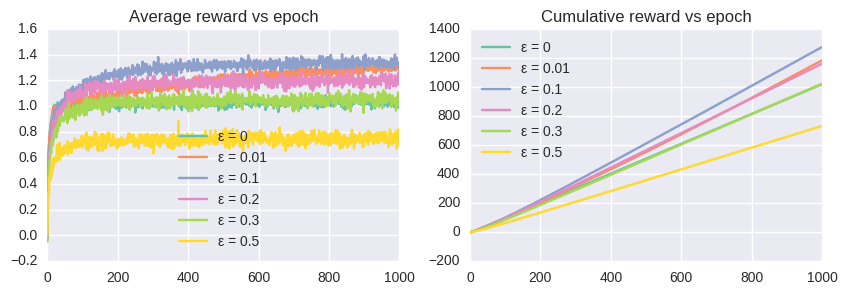

In [59]:
f, (ax0, ax1) = sns.plt.subplots(1,2, figsize=(10,3))
ax0.set_title('Average reward vs epoch')
ax1.set_title('Cumulative reward vs epoch')
for l, cr in enumerate(r):
    cm = np.mean(cr, axis=1)
    ax0.plot(cm, label=u"\u03B5 = {}".format(EPS[l]))
    ax1.plot(np.cumsum(cm), label=u"\u03B5 = {}".format(EPS[l]))
ax0.legend(loc='best');
ax1.legend(loc='best');

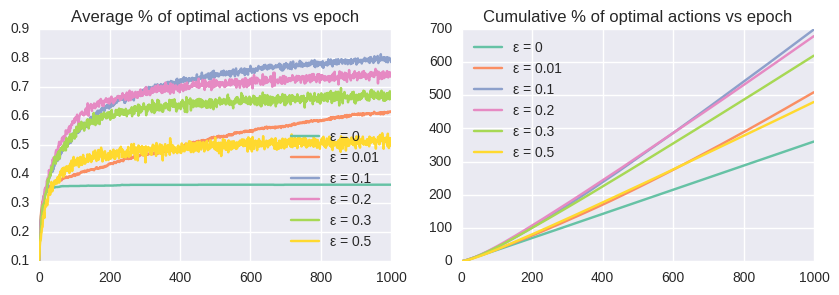

In [60]:
f, (ax0, ax1) = sns.plt.subplots(1,2, figsize=(10,3))
ax0.set_title('Average % of optimal actions vs epoch')
ax1.set_title('Cumulative % of optimal actions vs epoch')
for l, cb in enumerate(ba):
    cm = np.mean(cb, axis=1)
    ax0.plot(cm, label=u"\u03B5 = {}".format(EPS[l]))
    ax1.plot(np.cumsum(cm), label=u"\u03B5 = {}".format(EPS[l]))
ax0.legend(loc='best');
ax1.legend(loc='best');